# Essential Imports

In [1]:
from google.colab import drive
import gc
gc.collect()
import os
import numpy as np
import nibabel as nib 
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
import tensorflow as tf
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
     |████████████████████████████████| 50 kB 5.0 MB/s 
Segmentation Models: using `tf.keras` framework.


## Connecting to drive

In [3]:
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [4]:
%cd '/content/drive/MyDrive/Brain arterial segmentation/Preprocessed dataset'
datasetPath = os.getcwd()
os.listdir()

/content/drive/MyDrive/Brain arterial segmentation/Preprocessed dataset


# Helper functions

In [5]:
def generatingInputs(T1, groundtruth, sub):

    t1, groundseg = reshaping(T1, groundtruth)

    x_train = t1[0::2,:,:,:]
    y_train = groundseg[0::2,:,:,:]

    # print("x_train shape = " + str(x_train.shape))
    # print("y_train shape = " + str(y_train.shape))

    x_val = t1[1::2,:,:,:]
    y_val = groundseg[1::2,:,:,:]

    # print("x_val shape = " + str(x_val.shape))
    # print("y_val shape = " + str(y_val.shape))
    print("Ready for training {}".format(sub))
    return x_train, y_train, x_val, y_val
# plt.subplot(1,2,1); plt.imshow(t1[75,:,:,0]); plt.title('input')
# plt.subplot(1,2,2); plt.imshow(np.max(groundseg[60:65,:,:,0],axis=0)); plt.title('target')
# plt.show()
def reshaping(T1, groundtruth):
    # print("swapping axes...")
    t1 = T1
    groundseg = groundtruth
    groundseg = np.swapaxes(groundseg,0,2)
    t1 = np.swapaxes(t1,0,2)

    # print("t1 shape = " + str(t1.shape) + " groundseg shape = " + str(groundseg.shape))

    # print("expanding dimensions and tiling input...")
    groundseg = np.expand_dims(groundseg,axis=3)
    t1 = np.expand_dims(t1,axis=3)
    t1 = np.tile(t1,[1,1,1,3])

    return t1, groundseg
    # print("t1 shape = " + str(t1.shape) + " groundseg shape = " + str(groundseg.shape))

# Download resnet34 model

In [2]:
BACKBONE = 'resnet34'
# preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, input_shape=(None,None,3), encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)


85532672/85521592 [==============================] - 6s 0us/step


### retraining downloaded model

In [ ]:
i = 1
for j in range(20):
    sub = os.listdir()[j]
    groundseg = nib.load(sub+'/tof_arteries.nii.gz').get_fdata()
    t1 = nib.load(sub+'/t1_in_tof.nii.gz').get_fdata()
    print('Training {}'.format(sub))
    x_train, y_train, x_val, y_val = generatingInputs(t1, groundseg, sub)
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=16,
        epochs=100,
        validation_data=(x_val, y_val)
    )
model.save("Final model.h5")

In [ ]:
# Loading trained model

In [6]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Brain arterial segmentation/trained_model.h5', custom_objects={'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss, 'iou_score': sm.metrics.iou_score})
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

### Testing

(163, 640, 480, 1)


Text(0.5, 1.0, 'Sub-20 ground truth')

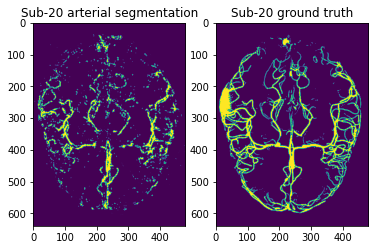

In [ ]:
groundseg = nib.load('/content/drive/MyDrive/Dataset/sub-20/tof_arteries.nii.gz').get_fdata()
t1   = nib.load('/content/drive/MyDrive/Dataset/sub-20/t1_in_tof.nii.gz').get_fdata()
t1, groundseg = reshaping(t1, groundseg)
preds = model.predict(t1)
print(preds.shape)
plt.subplot(1,2,1);plt.imshow(np.max(preds[:,:,:,0],axis=0))
plt.title('Sub-20 arterial segmentation')
plt.subplot(1,2,2);plt.imshow(np.max(groundseg[:,:,:,0],axis=0))
plt.title('Sub-20 ground truth')

In [ ]:
groundseg = nib.load('/content/drive/MyDrive/Dataset/sub-20/tof_arteries.nii.gz').get_fdata()
groundseg.shape

(480, 640, 163)